In [1]:
#imports 
import os
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import DataLoader,Dataset


import spacy
import statistics
import torchtext
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import matplotlib.pyplot as plt


import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.metrics import Accuracy

In [11]:
print(torch.__version__)

1.5.0


In [2]:
torch.backends.cudnn.benchmark = True
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
BATCH_SIZE = 64
NUM_WORKERS = 8
SPLIT_VAL = 0.2

EMBED_SIZE = 256
HIDDEN_SIZE = 256
NUM_LAYERS = 1

LRATE = 3e-4
MAX_EPOCHS = 100
NUM_GPU=1

In [12]:
class Vocabulary:
    def __init__(self, freq_threshold, spacy_eng=None):
        self.start_word = "<SOS>"
        self.end_word = "<EOS>"
        self.pad_word = "<PAD>"
        self.unk_word = "<UNK>"
        
        self.itos = {0: self.pad_word, 1: self.start_word, 2: self.end_word, 3: self.unk_word}
        self.stoi = {self.pad_word: 0, self.start_word: 1, self.end_word: 2, self.unk_word: 3}
        
        self.itos = {0: self.start_word, 1: self.end_word, 2: self.pad_word, 3: self.unk_word}
        self.stoi = {self.start_word: 0, self.end_word: 1, self.pad_word: 2, self.unk_word: 3}
        
        
        self.freq_threshold = freq_threshold
        if spacy_eng==None:
            self.spacy_eng = spacy.load('en_core_web_sm')
        else:
            self.spacy_eng = spacy_eng
        

    def __len__(self):
        return len(self.itos)

    def tokenizer_eng(self, text):
        tokenizer = [tok.text.lower() for tok in self.spacy_eng.tokenizer(text)]
        return tokenizer
        
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, caption_file, caption_delimiter='|', 
                 transform=None, freq_threshold=5,
                 train=True, split_val=0.2):
        self.root_dir = root_dir
        self.caption_file = caption_file
        self.df = pd.read_csv(caption_file, delimiter=caption_delimiter)
        self.transform = transform
        
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.df['caption_text'].tolist())
        
        self.train = train 
        self.split_val = split_val
        self._do_split_train_valid()
        
#         # Get img, caption columns
#         self.imgs = self.df["image"]
#         self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab

        
    def _do_split_train_valid(self):
        imgs_train, imgs_valid, caps_train, caps_valid = train_test_split(
            self.df["image_name"], self.df["caption_text"], 
            test_size=self.split_val, random_state=16
        )
        
        if self.train:
            self.imgs = imgs_train
            self.captions = caps_train
        else:
            self.imgs = imgs_valid
            self.captions = caps_valid
            
        self.imgs = self.imgs.tolist()
        self.captions = self.captions.tolist()
        

    def __len__(self):
        return len(self.imgs)
    
    def _numericalized_caption(self, caption):
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return numericalized_caption

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        ncaption = self._numericalized_caption(caption)

        return img, torch.tensor(ncaption)


class CaptionCollate:
    def __init__(self, pad_idx, batch_first=True):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)

        return imgs, targets
    

def flickr8k_dataloader(root_folder, caption_file, transform, train=True,
                        batch_size=32, num_workers=8, shuffle=True, pin_memory=True):
    
    dataset = FlickrDataset(root_folder, caption_file, transform=transform, train=train)
    PAD_IDX = dataset.vocab.stoi["<PAD>"]
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=num_workers,
                            shuffle=shuffle, pin_memory=pin_memory, 
                            collate_fn=CaptionCollate(pad_idx=PAD_IDX))
    
    return dataloader, dataset

In [13]:
train_transform = transforms.Compose([
    transforms.Resize((356, 356)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
])

root_dir = "data/flickr8k/images/"
caption_file = "data/flickr8k/captions.txt"

train_loader, trainset = flickr8k_dataloader(root_dir, caption_file, transform=train_transform,  
                                             num_workers=NUM_WORKERS, shuffle=True, train=True)

valid_loader, validset = flickr8k_dataloader(root_dir, caption_file, transform=valid_transform, 
                                             num_workers=NUM_WORKERS, shuffle=False, train=False)

In [5]:
class BiLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size:int, num_layers:int, batch_first=True):
        super(BiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_first = batch_first
        
        self.rnn: nn.LSTM = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True, batch_first=batch_first)
        self.linear: nn.Linear = nn.Linear(hidden_size * 2, output_size)
        
        
    def forward(self, x: torch.Tensor):
        """[summary]
        
        x: visual features [batch x T x input_size]
        return x: contextual feature [batch x T x output_size]

        Args:
            x ([torch.Tensor]): [visual features [batch x T x input_size]]

        Returns:
            [type]: [description]
        """
        
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(x) # batch_size x T x input_size -> batch_size x T x (2*hidden_size)
        output = self.linear(recurrent) # batch_size x T x output_size
        
        return output

class Encoder(nn.Module):
    def __init__(self, embed_size, train_cnn=False, resnet_model=models.resnet50):
        super(Encoder, self).__init__()
        self.train_cnn = train_cnn
        resnet = resnet_model(pretrained=True)
        resnet = self._fine_tune(resnet)
        modules = list(resnet.children())[:-1]
        
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
#         self.dropout = nn.Dropout(0.5)
        
    def _fine_tune(self, resnet):
        if self.train_cnn:
            for param in resnet.parameters():
                param.requires_grad_(True)
        else:
            for param in resnet.parameters():
                param.requires_grad_(False)
                
        return resnet
    
    
    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        embed = self.embed(features)
        return embed


class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_size * 2, hidden_size)
#         self.sequence = BiLSTM(embed_size, hidden_size, hidden_size, num_layers)
        self.prediction = nn.Linear(hidden_size, vocab_size)
#         self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions, max_len=20):
        captions = captions[:, :-1]
        features = features.unsqueeze(dim=1)
        
        embeddings = self.embed(captions)
        embeddings = torch.cat((features, embeddings), dim=1)
#         packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        outputs = self.prediction(outputs)
        return outputs


class ImageCaptionNet(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(ImageCaptionNet, self).__init__()
        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs
    
    def sample(self, images, states=None, max_len=20):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        x = self.encoder(images).unsqueeze(dim=1)
        
        word_indexs = []
        for i in range(max_len):
            hiddens, states = self.decoder.sequence(x, states)
            outputs = self.decoder.linear(hiddens)
            outputs = self.decoder.prediction(output)
            outputs = outputs.squeeze(dim=1)
            word_idx = outputs.argmax(dim=1)
            word_indexs.append(word_idx.item())
            x = self.decoder.embed(word_idx.unsqueeze(dim=0))
        return word_indexs
    
    

In [6]:
class ImageCaptionTask(pl.LightningModule):
    def __init__(self, model, optimizers, criterion, vocab_size, scheduler=None):
        super().__init__()
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.vocab_size = vocab_size
        self.metric = Accuracy()
        
    def forward(self, imgs, captions):
        outputs = self.model(imgs, captions[:-1])
        return outputs
        
    
    def shared_step(self, batch, batch_idx):
        imgs, captions = batch
        outputs = self.model(imgs, captions)
        
        outputs_pre = outputs.view(-1, self.vocab_size)
        captions_pre = captions.view(-1)
        loss = criterion(outputs_pre, captions_pre)
#         acc = (output.argmax(1) == cls).sum().item()
        acc = self.metric(outputs_pre.argmax(1), captions_pre)
        return loss, acc

    
    def training_step(self, batch, batch_idx):
        loss, acc = self.shared_step(batch, batch_idx)
        result = pl.TrainResult(loss)
#         result.log_dict({'trn_loss': loss})
        result.log_dict({'trn_loss': loss, 'trn_acc':acc})
        
        return result
    
    def validation_step(self, batch, batch_idx):
        loss, acc = self.shared_step(batch, batch_idx)
        result = pl.EvalResult(checkpoint_on=loss)
#         result.log_dict({'val_loss': loss})
        result.log_dict({'val_loss': loss, 'val_acc': acc})
        
        return result
    
    def configure_optimizers(self):
        if self.scheduler:
            return [self.optimizer], [self.scheduler]
        return self.optimizer
    
  

In [7]:
def clean_sentence(output, vocab):
    sentence = ""
    for i in output:
        word = vocab.itos[i]
        if (word == vocab.start_word):
            continue
        elif (word == vocab.end_word):
            break
        else:
            sentence = sentence + " " + word
    return sentence

In [8]:
# initialize model, loss etc
PAD_INDEX = trainset.vocab.stoi["<PAD>"]
VOCAB_SIZE = len(trainset.vocab)

model = ImageCaptionNet(EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE, NUM_LAYERS)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_INDEX)
optimizer = optim.Adam(model.parameters(), lr=LRATE)
task = ImageCaptionTask(model, optimizer, criterion, VOCAB_SIZE)

In [10]:
saved_checkpoint_path = '../saved_model/flickr8k_net_epoch=1.ckpt'
checkpoint = torch.load(saved_checkpoint_path, map_location=lambda storage, loc: storage)
task.load_state_dict(checkpoint['state_dict'])
# model.load_state_dict(task.model.state_dict())
# task.load_from_checkpoint(saved_checkpoint_path, optimizers=optimizer, criterion=criterion, vocab_size=VOCAB_SIZE)

RuntimeError: Error(s) in loading state_dict for ImageCaptionTask:
	Unexpected key(s) in state_dict: "model.decoder.lstm.weight_ih_l1", "model.decoder.lstm.weight_hh_l1", "model.decoder.lstm.bias_ih_l1", "model.decoder.lstm.bias_hh_l1", "model.decoder.lstm.weight_ih_l1_reverse", "model.decoder.lstm.weight_hh_l1_reverse", "model.decoder.lstm.bias_ih_l1_reverse", "model.decoder.lstm.bias_hh_l1_reverse". 

In [42]:
# saved_checkpoint_path = '../saved_model/flickr8k_net_epoch=66.ckpt'
# checkpoint = torch.load(saved_checkpoint_path, map_location=lambda storage, loc: storage)
# state_dict =checkpoint['state_dict']

# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in state_dict.items():
# #     name = k[7:] # remove 'module.' of dataparallel
# #     new_state_dict[name]=v
#     name = k.replace("model.","")
#     new_state_dict[name] = v
#     if 'rnn' in name:
#         print(name)
    
# model.decoder.sequence.rnn.weight_ih_l0
    

# model.load_state_dict(new_state_dict)

decoder.sequence.rnn.weight_ih_l0
decoder.sequence.rnn.weight_hh_l0
decoder.sequence.rnn.bias_ih_l0
decoder.sequence.rnn.bias_hh_l0
decoder.sequence.rnn.weight_ih_l0_reverse
decoder.sequence.rnn.weight_hh_l0_reverse
decoder.sequence.rnn.bias_ih_l0_reverse
decoder.sequence.rnn.bias_hh_l0_reverse
decoder.sequence.rnn.weight_ih_l1
decoder.sequence.rnn.weight_hh_l1
decoder.sequence.rnn.bias_ih_l1
decoder.sequence.rnn.bias_hh_l1
decoder.sequence.rnn.weight_ih_l1_reverse
decoder.sequence.rnn.weight_hh_l1_reverse
decoder.sequence.rnn.bias_ih_l1_reverse
decoder.sequence.rnn.bias_hh_l1_reverse


RuntimeError: Error(s) in loading state_dict for ImageCaptionNet:
	Unexpected key(s) in state_dict: "decoder.sequence.rnn.weight_ih_l1", "decoder.sequence.rnn.weight_hh_l1", "decoder.sequence.rnn.bias_ih_l1", "decoder.sequence.rnn.bias_hh_l1", "decoder.sequence.rnn.weight_ih_l1_reverse", "decoder.sequence.rnn.weight_hh_l1_reverse", "decoder.sequence.rnn.bias_ih_l1_reverse", "decoder.sequence.rnn.bias_hh_l1_reverse". 

In [14]:
# checkpoint['state_dict']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted    :  a man in a blue shirt and jeans is sitting on a bench .
ground truth :  a young girl wearing sandals carries what appears to be <UNK> of some sort .


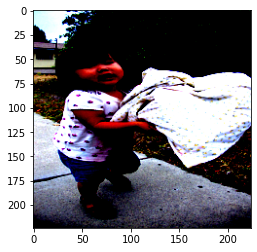

In [259]:
img, txt = validset[10000]
img = img.unsqueeze(0)

word_indexs = model.sample(img)
result = clean_sentence(word_indexs, validset.vocab)

print(f'predicted    : {result}')
print(f'ground truth : {clean_sentence(txt.tolist(), validset.vocab)}')
plt.imshow(img.squeeze().permute(1,2,0), cmap='gray')


[1, 4, 61, 28, 8, 4, 57, 83, 17, 41, 12, 192, 2]

In [46]:
# with torch.no_grad():
#     feature = model.encoderCNN(img)
#     feature = feature.unsqueeze(dim=1)
#     states = None
    
#     max_length = 25
#     text = []
#     for i in range(max_length):
#         hiddens, states = model.decoderRNN.lstm(feature, states)
#         output = model.decoderRNN.linear(hiddens.squeeze(0))
#         predicted = output.argmax(dim=1)
#         txt = trainset.vocab.itos[predicted.item()]
#         text.append(txt)
#         feature = model.decoderRNN.embed(predicted).unsqueeze(1)
    



In [129]:
train_loader.dataset.vocab